# SSAP

In [1]:
%matplotlib inline

import sys
import os
import copy
import random
import datetime

import numpy as np
import pickle
import glob
from tqdm import tqdm
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import optim
from pycocotools.coco import COCO

In [2]:
sys.path.append('../src/')

from SSAP import DoubleConv, Down, Up, OutConv, SSAP
from mydatasets import preprocess, Mydatasets
from loss import focal_loss, l2_loss, calc_loss
from graph_partition import Partition, Edge, greedy_additive, \
                            calc_js_div, make_ins_seg

## Prepare

In [3]:
# classとclassの色の呼び出し
with open('../data/t_class_name.txt', 'rb') as f:
    t_class_name = pickle.load(f)
with open('../data/t_color.txt', 'rb') as f:
    t_color = pickle.load(f)

In [9]:
DATA_PATH = "../data/resize_224/"
IMG_SIZE = 224
# Affinity計算範囲
AFF_R = 5

mean = [0.477, 0.451, 0.411]
std = [0.284, 0.280, 0.292]

In [5]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [6]:
model = SSAP(n_channels=3, n_classes=len(t_color), aff_r=AFF_R)
model = model.to(device)

## Train

In [13]:
# 実験ごとに名前(exp_1)を変更する.
name = "../exp/exp_1/"

!mkdir -p $name
graph = name + "graph/"
!mkdir -p $graph
metrics = name + "metrics/"
!mkdir -p $metrics
trained_model = name + "trained_model/"
!mkdir -p $trained_model

BATCH_SIZE = 10

EPOCH = 100000
SAVE_ITER = 50
LOG_ITER = 10

aff_calc_weight = [1.5, 0.5]
aff_weight = 1.
l_aff_weight = [1., 0.3, 0.1, 0.03, 0.01]

In [14]:
# 各値の初期化
random.seed(0)  
np.random.seed(0)  
torch.manual_seed(0)
img_path = DATA_PATH + "train2014/"
img_t_path = DATA_PATH + "semantic_train/"
img_t_ins_path = DATA_PATH + "instance_train/"

In [15]:
# Datasetの設定
dataset = Mydatasets(t_color, img_path, img_t_path, img_t_ins_path,
                     IMG_SIZE, AFF_R, mean, std)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE,
                                          shuffle = True, num_workers = 4)

In [16]:
# Optimizerの指定
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)

In [ ]:
iter_ = 0
running_loss = 0.0
running_loss_seg = 0.0
running_loss_aff = 0.0
y_loss_axis = []
y_loss_seg_axis = []
y_loss_aff_axis = []
x_axis = []

for epoch in range(EPOCH):  
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels, t_aff = data
        inputs = inputs.to(device)
        labels = labels.type(torch.float32)
        labels = labels.to(device)
        t_aff = t_aff.type(torch.float32)
        t_aff = t_aff.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        loss_seg, loss_aff = calc_loss(outputs, labels, 
                                       t_aff, aff_calc_weight, 
                                       aff_weight, l_aff_weight)
        loss = loss_seg + loss_aff
        loss.backward()
        optimizer.step()
        running_loss += loss.data
        running_loss_seg += loss_seg.data
        running_loss_aff += loss_aff.data

        iter_ += 1
        
        # logの表示
        if iter_ % LOG_ITER == 0:
            with open(name + "log", mode='a') as f:
                f.write("time:{}, epoch:{}, iter:{}, loss:{:.4f}, loss_seg:{:.4f}, loss_aff:{:.4f}\n"
                        .format(datetime.datetime.now(), epoch, iter_, 
                                loss.data, loss_seg.data, loss_aff.data))
            print("iter:{}, loss:{:.4f}, loss_seg:{:.4f}, loss_aff:{:.4f}"
                  .format(iter_, loss.data, loss_seg.data, loss_aff.data))

        if iter_ % SAVE_ITER == 0:
            # lossのグラフ作成
            x_axis.append(iter_)
            y_loss_axis.append(running_loss / SAVE_ITER)
            y_loss_seg_axis.append(running_loss_seg / SAVE_ITER)
            y_loss_aff_axis.append(running_loss_aff / SAVE_ITER)

            fig = plt.figure()
            plt.xlabel("iter")
            plt.ylabel("loss")
            plt.plot(np.array(x_axis),np.array(y_loss_axis))
            fig.savefig(graph + "loss.png")

            fig = plt.figure()
            plt.xlabel("iter")
            plt.ylabel("loss_seg")
            plt.plot(np.array(x_axis),np.array(y_loss_seg_axis))
            fig.savefig(graph + "loss_seg.png")

            fig = plt.figure()
            plt.xlabel("iter")
            plt.ylabel("loss_aff")
            plt.plot(np.array(x_axis),np.array(y_loss_aff_axis))
            fig.savefig(graph + "loss_aff.png")            

            running_loss = 0.0
            running_loss_seg = 0.0
            running_loss_aff = 0.0

            torch.save(model.state_dict(), trained_model + "model_" + str(iter_) + ".pth")

print('Finished Training')

# test

In [19]:
# 評価するモデルとiterationを指定.
pre_name = "../exp/exp_1/"
iter_ = "750000"
model = SSAP(n_channels=3, n_classes=len(t_color), aff_r=AFF_R)
model = model.to(device)
model.eval()
model.load_state_dict(torch.load(pre_name + 'trained_model/model_' + iter_ + '.pth'))

<All keys matched successfully>

In [20]:
data_type = "val"
img_path = sorted(glob.glob(DATA_PATH + data_type + "2014/*"))
img_t_path = sorted(glob.glob(DATA_PATH + "semantic_" + data_type + "/*"))
img_ins_t_path = sorted(glob.glob(DATA_PATH + "instance_" + data_type + "/*"))
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])

In [21]:
# cocoデータセット呼び出し
annFile='../data/annotations/instances_%s2014.json'%(data_type)
coco=COCO(annFile)

loading annotations into memory...
Done (t=3.96s)
creating index...
index created!


In [22]:
# クラスとcocoデータセット内でのIndexを渡すと、評価データ内のIndexを返す.
def get_img_ind(cls_ind=0, img_ind=0):
    catIds = coco.getCatIds(catNms=[t_class_name[cls_ind]]);
    imgIds = sorted(coco.getImgIds(catIds=catIds));
    img_name = coco.loadImgs(imgIds[img_ind])[0]['file_name']
    img_name = DATA_PATH + data_type + "2014/" + img_name
    ind_ = img_path.index(img_name)
    print(t_class_name[cls_ind], ind_)
    return ind_

In [23]:
# Semantic Segmentation
def semantic(ind=0, cls_=0):
    img = np.asarray(Image.open(img_path[ind]))
    img_t = np.asarray(Image.open(img_t_path[ind]))
    img_ins_t = np.asarray(Image.open(img_ins_t_path[ind]))
    img_t = np.where((img_t[:, :, 0] == t_color[cls_][0])
                     & (img_t[:, :, 1] == t_color[cls_][1])
                     & (img_t[:, :, 2] == t_color[cls_][2]),
                     1, 0)[..., None]
    img_ins_t = img_ins_t * img_t
    img_t = np.tile(img_t, (1, 1, 3))

    img = preprocess(img)
    
    inputs = torch.zeros((1, 3, IMG_SIZE, IMG_SIZE))

    inputs[0] = transform(img)
    
    with torch.no_grad():
        outputs = model(inputs.to(device))
    
    print("pic_name:{}".format(img_path[ind]))

    output = outputs[4].cpu().detach().numpy()
    output = np.array(np.argmax(output[0], axis=0))
    output = np.where(output==cls_, 1, 0)

    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(131, title='input')
    ax1.imshow(np.array(img, dtype=np.int32))
    ax2 = fig.add_subplot(132, title='correct_instance')
    ax2.imshow(np.array(img_ins_t, dtype=np.int32))
    ax3 = fig.add_subplot(133, title='detect_instance')
    ax3.imshow(output)
    plt.show()

    return outputs

In [24]:
# Instance Segmentation
def instance(ind=0, cls_=0, st_for=0, en_for=5, min_size=5):
    img = np.asarray(Image.open(img_path[ind]))
    img_t = np.asarray(Image.open(img_t_path[ind]))
    img_ins_t = np.asarray(Image.open(img_ins_t_path[ind]))
    img_t = np.where((img_t[:, :, 0] == t_color[cls_][0])
                      & (img_t[:, :, 1] == t_color[cls_][1])
                      & (img_t[:, :, 2] == t_color[cls_][2]),
                     1, 0)[..., None]
    img_ins_t = img_ins_t * img_t
    img_t = np.tile(img_t, (1, 1, 3))

    img = preprocess(img)
    
    inputs = torch.zeros((1, 3, IMG_SIZE, IMG_SIZE))

    inputs[0] = transform(img)
    
    with torch.no_grad():
        outputs = model(inputs.to(device))
    
    print("pic_name:{}".format(img_path[ind]))
    
    ins, ins_list = make_ins_seg(outputs, st_for=st_for,
                                 en_for=en_for, min_size=min_size)

    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(131, title='input')
    ax1.imshow(np.array(img, dtype=np.int32))
    ax2 = fig.add_subplot(132, title='correct_instance')
    ax2.imshow(np.array(img_ins_t, dtype=np.int32))
    ax3 = fig.add_subplot(133, title='detect_instance')
    ax3.imshow(ins[cls_])
    plt.show()

    return outputs, ins

person 1851
pic_name:./coco_dataset_2014/resize_224/val2014/COCO_val2014_000000026024.jpg


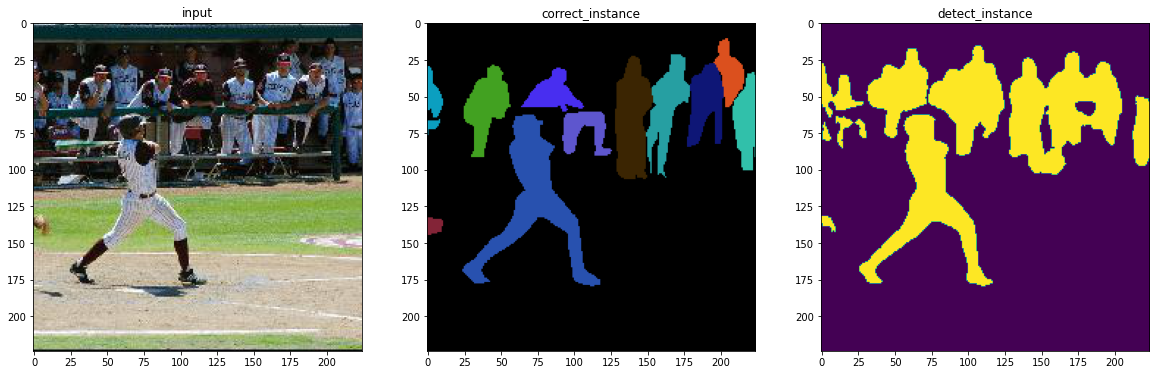

In [13]:
cls_ind = 0
img_ind = 1000
ind = get_img_ind(cls_ind, img_ind)
outputs = semantic(ind=ind, cls_=cls_ind)

person 1851
pic_name:./coco_dataset_2014/resize_224/val2014/COCO_val2014_000000026024.jpg


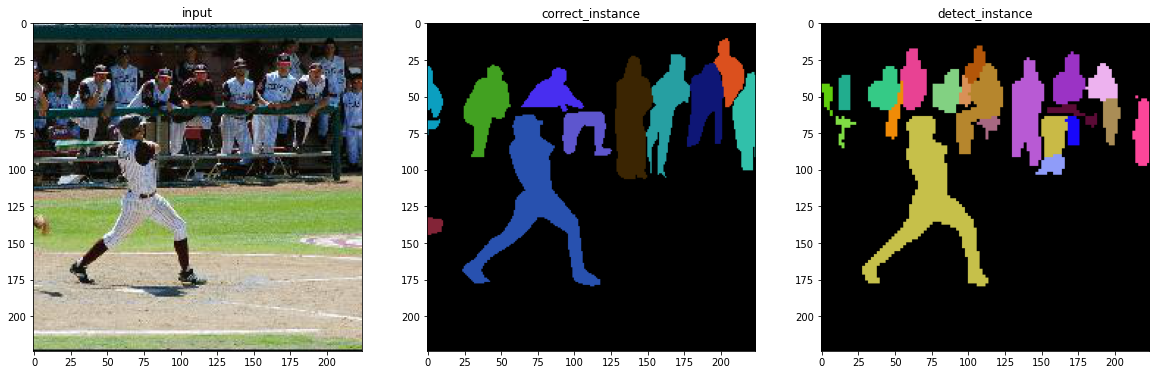

In [14]:
cls_ind = 0
img_ind = 1000
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

person 9638
pic_name:./coco_dataset_2014/resize_224/val2014/COCO_val2014_000000138728.jpg


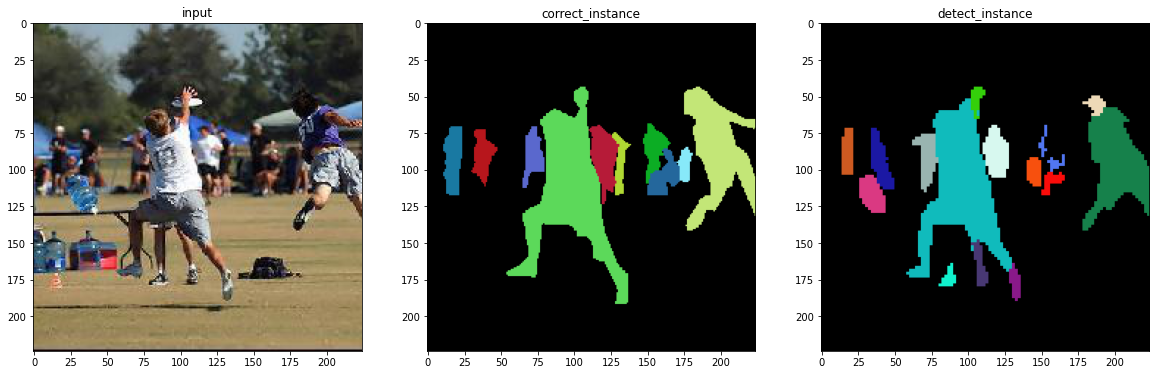

In [15]:
cls_ind = 0
img_ind = 5105
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

elephant 9932
pic_name:./coco_dataset_2014/resize_224/val2014/COCO_val2014_000000142949.jpg


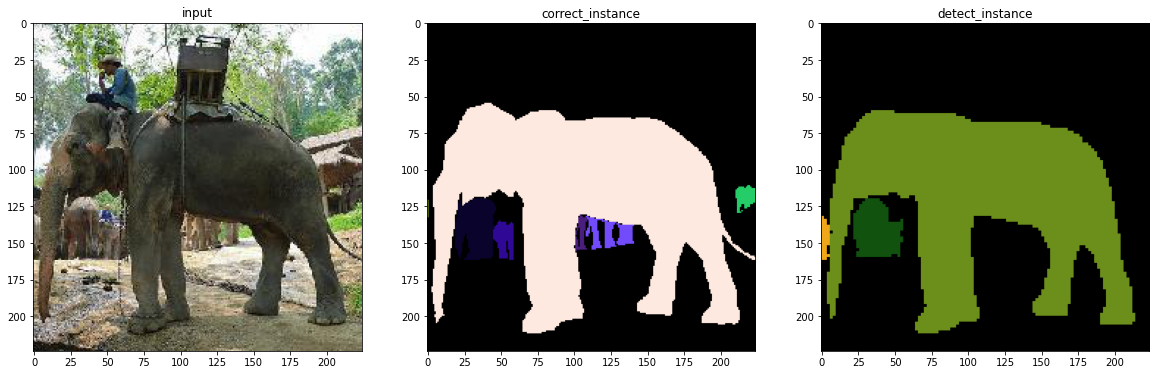

In [16]:
cls_ind = 20
img_ind = 200
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

keyboard 2630
pic_name:./coco_dataset_2014/resize_224/val2014/COCO_val2014_000000036484.jpg


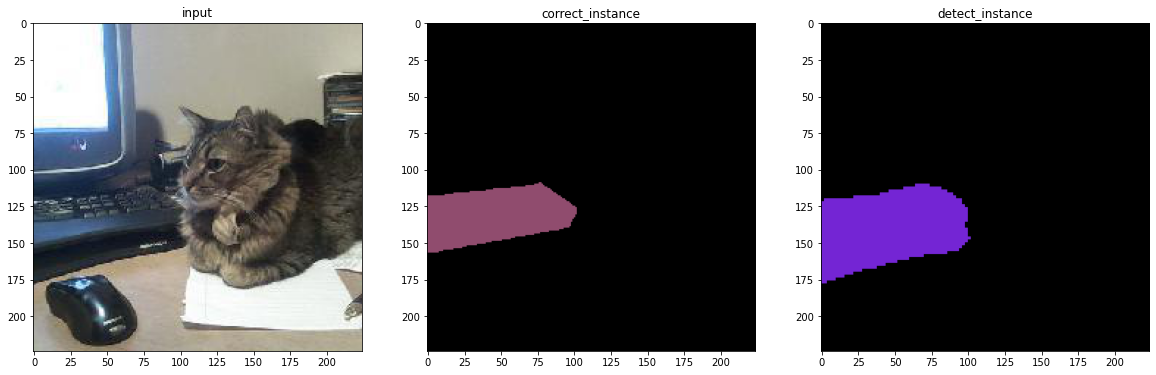

In [21]:
cls_ind = 66
img_ind = 44
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

stop sign 401
pic_name:./coco_dataset_2014/resize_224/val2014/COCO_val2014_000000005635.jpg


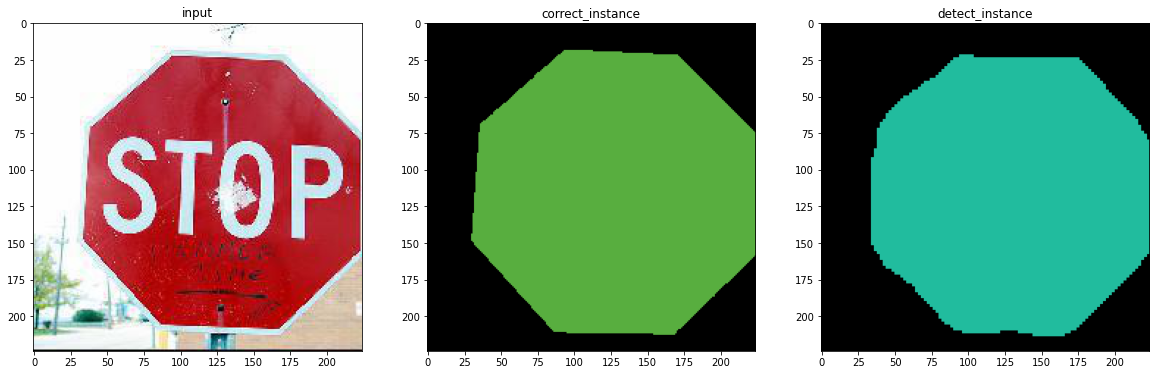

In [42]:
cls_ind = 11
img_ind = 3
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

fork 24806
pic_name:./coco_dataset_2014/resize_224/val2014/COCO_val2014_000000356349.jpg


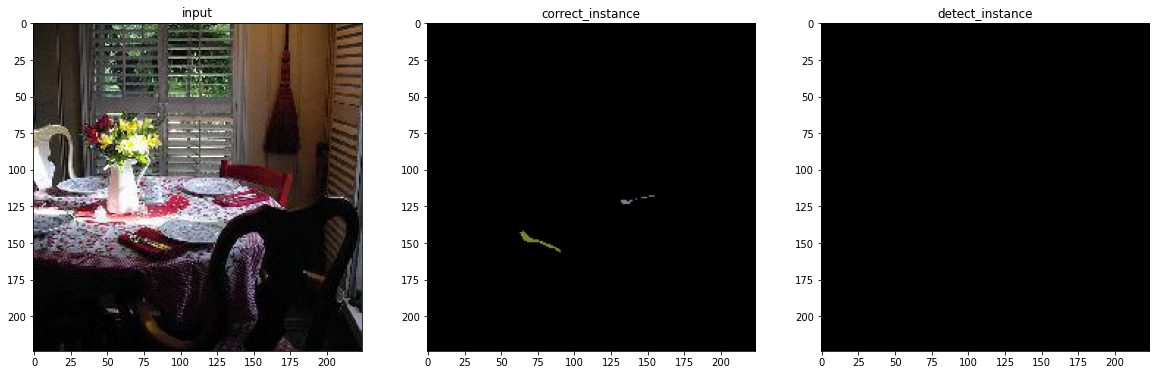

In [63]:
cls_ind = 42
img_ind = 736
ind = get_img_ind(cls_ind, img_ind)
outputs = instance(ind=ind, cls_=cls_ind, st_for=0, en_for=4, min_size=20)

## Calc metrics

In [21]:
# mIoU
intersection = np.zeros((len(t_color)-1))
union = np.zeros((len(t_color)-1))
iou = np.zeros((len(t_color)-1))
t_area = np.zeros((len(t_color)-1))

for ind in tqdm(range(len(img_path))):
    img = np.asarray(Image.open(img_path[ind]))
    img_t = np.asarray(Image.open(img_t_path[ind]))

    img = preprocess(img)

    inputs = torch.zeros((1, 3, IMG_SIZE, IMG_SIZE))
    inputs[0] = transform(img)

    with torch.no_grad():
        outputs = model(inputs.to(device))

    output = outputs[4].cpu().detach().numpy()
    output = np.array(np.argmax(output[0], axis=0))

    for cls_ in range(len(t_color)-1):
        output_cls = np.where(output==cls_, 1, 0)
        img_t_cls = np.where((img_t[:, :, 0] == t_color[cls_][0])
                             & (img_t[:, :, 1] == t_color[cls_][1])
                             & (img_t[:, :, 2] == t_color[cls_][2]), 1, 0)
        union[cls_] += np.sum(np.where((output_cls + img_t_cls)>0, 1, 0))
        intersection[cls_] += np.sum(output_cls * img_t_cls)
        t_area[cls_] += np.sum(img_t_cls)

for cls_ in range(len(t_color)-1):
    if union[cls_] == 0:
        iou[cls_] = 0
    else:
        iou[cls_] = intersection[cls_] / union[cls_]

with open(metrics + "metrics_mIoU", mode='w') as f:
    f.write("mIoU:{:.3f}\n"
            .format(np.mean(np.array(iou))))
    for i in range(len(t_color)-1):
        f.write("{}, IoU:{:.3f}, {}, union:{}, t_area:{}, intersection:{}\n"
            .format(i, iou[i], t_class_name[i], union[i],
                    t_area[i], intersection[i]))

np.save(metrics + 'intersection', intersection)
np.save(metrics + 'union', union)
np.save(metrics + 'iou', iou)
np.save(metrics + 't_area', t_area)

100%|██████████| 40504/40504 [53:01<00:00, 12.73it/s]


In [ ]:
# PQ(Panoptic Quality), AP(Average Precision)の計算
TP = np.zeros((len(t_color)-1))
FP = np.zeros((len(t_color)-1))
FN = np.zeros((len(t_color)-1))
IoU_05 = [[] for i in range(len(t_color)-1)]
IoU = np.zeros((len(t_color)-1))
AP = np.zeros((len(t_color)-1))
SQ = np.zeros((len(t_color)-1))
RQ = np.zeros((len(t_color)-1))

st_for=0
en_for=4
min_size=20

for ind in tqdm(range(len(img_path))):
    img = np.asarray(Image.open(img_path[ind]))
    seg_t = np.asarray(Image.open(img_t_path[ind]))
    ins_t = np.asarray(Image.open(img_ins_t_path[ind]))

    img = preprocess(img)
    
    inputs = torch.zeros((1, 3, IMG_SIZE, IMG_SIZE))

    inputs[0] = transform(img)
    
    with torch.no_grad():
        outputs = model(inputs.to(device))
        
    detect, ins_list = make_ins_seg(outputs, st_for=st_for,
                                    en_for=en_for, min_size=min_size)

    for cls_ in range(len(t_color)-1):
        # Falseだと、そのクラスが画像中に存在していないことを示す.
        t_flag = False
        d_flag = False

        # 正解ラベル
        # 該当クラスのinstanceのみ取り出す
        mask = np.where((seg_t[:, :, 0] == t_color[cls_][0])
                        & (seg_t[:, :, 1] == t_color[cls_][1])
                        & (seg_t[:, :, 2] == t_color[cls_][2]),
                        1, 0)[..., None]
        ins_t_cls = ins_t * mask
        if np.max(ins_t_cls)!=0:
            t_flag = True
            # instanceを一つずつ224x224のndarrayに分ける
            ins_colors = ins_t_cls.reshape(IMG_SIZE*IMG_SIZE, 3)
            ins_colors = sorted(list(map(list, set(map(tuple, ins_colors)))))[::-1]
            if [0, 0, 0] in ins_colors:
                ins_colors.remove([0, 0, 0])
            t_com = np.zeros((len(ins_colors), IMG_SIZE, IMG_SIZE))

            for i in range(len(ins_colors)):
                t_com[i] = np.where((ins_t_cls[:, :, 0] == ins_colors[i][0])
                                    & (ins_t_cls[:, :, 1] == ins_colors[i][1])
                                    & (ins_t_cls[:, :, 2] == ins_colors[i][2]), 1, 0)

        # 識別結果
        # instanceを一つずつ224x224のndarrayに分ける
        if np.max(detect[cls_])!=0:
            d_flag = True
            ins_colors = detect[cls_].reshape(IMG_SIZE*IMG_SIZE, 3)
            ins_colors = sorted(list(map(list, set(map(tuple, ins_colors)))))[::-1]
            if [0, 0, 0] in ins_colors:
                ins_colors.remove([0, 0, 0])
            det_com = np.zeros((len(ins_colors), IMG_SIZE, IMG_SIZE))
            for i in range(len(ins_colors)):
                det_com[i] = np.where((detect[cls_][:, :, 0] == ins_colors[i][0])
                                      & (detect[cls_][:, :, 1] == ins_colors[i][1])
                                      & (detect[cls_][:, :, 2] == ins_colors[i][2]), 1, 0)

        # t_comとdet_comを比較.
        if t_flag == False and d_flag == False:
            continue
        elif t_flag == True and d_flag == False:
            FN[cls_] += len(t_com)
        elif t_flag == False and d_flag == True:
            FP[cls_] += len(det_com)
        else:
            TP_cls = 0
            for i in range(len(det_com)):
                union = np.sum(np.sum(np.clip(t_com + det_com[i], 0, 1), axis=2), axis=1)
                intersection = np.sum(np.sum(t_com * det_com[i], axis=2), axis=1)

                max_IoU = np.max(intersection / union)
                if max_IoU > 0.5:
                    TP_cls += 1
                    IoU[cls_] += max_IoU
                    IoU_05[cls_].append(max_IoU)
            TP[cls_] += TP_cls
            FP[cls_] += len(det_com) - TP_cls
            FN[cls_] += len(t_com) - TP_cls
            
    if ind % 100 == 0:
        with open(metrics + "log", mode='a') as f:
            f.write("index:{}\n".format(ind))

np.save(metrics + 'TP', TP)
np.save(metrics + 'FP', FP)
np.save(metrics + 'FN', FN)
np.save(metrics + 'PQ_IoU', IoU)

for cls_ in range(len(t_color)-1):
    # Segmentation Quality
    if TP[cls_] == 0:
        SQ[cls_] = 0
    else:
        SQ[cls_] = np.array(IoU[cls_]) / np.array(TP[cls_])
    # Recognition Quality
    denominator = TP[cls_] + FP[cls_]/2 + FN[cls_]/2
    if denominator == 0:
        RQ[cls_] = 0
    else:
        RQ[cls_] = TP[cls_] / denominator
    
    # APの計算
    TP_FP = TP[cls_] + FP[cls_]
    if TP_FP == 0:
        AP[cls_] = 0
        continue
    for thresh in range(50, 100, 5):
        th = thresh / 100
        iou_05 = np.asarray(IoU_05[cls_])
        AP[cls_] += np.sum(np.where(iou_05>th, 1, 0)) / TP_FP
AP = AP / 10

# Panoptic Quality
PQ = SQ * RQ

with open(metrics + "metrics_mAP_mPQ", mode='w') as f:
    f.write("mAP{}, mPQ:{}\n"
            .format(np.mean(AP), np.mean(PQ)))
    for i in range(len(t_color)-1):
        f.write("{}, AP:{:.3f}, PQ:{:.3f}, {}\n"
            .format(i, AP[i], PQ[i], t_class_name[i]))

np.save(metrics + 'SQ', SQ)
np.save(metrics + 'RQ', RQ)
np.save(metrics + 'PQ', PQ)
np.save(metrics + 'AP', AP)